In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Flatten, concatenate, Dropout, Multiply, Reshape, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
df = pd.read_csv('CIC_IDS_2017_merged_filtered_data.csv')

In [3]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0.001221,0.000319,0.000000,0.000003,4.651163e-07,9.153974e-09,0.000242,0.002581,0.001010,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.005936,0.000004,0.000046,0.000017,1.333333e-05,4.973659e-07,0.003183,0.000000,0.002632,0.004414,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.001343,0.000009,0.000041,0.000021,2.441860e-04,4.805836e-06,0.063457,0.000000,0.053023,0.088773,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.005936,0.000127,0.000073,0.000041,2.675969e-04,1.016091e-05,0.052901,0.000000,0.034180,0.059753,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.001343,0.000009,0.000036,0.000021,2.441860e-04,4.808888e-06,0.063457,0.000000,0.058914,0.097467,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [4]:
# Strip spaces from the column names in df
df.columns = df.columns.str.strip()

# Define selected features
selected_features = [
    'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 
    'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Std', 
    'Bwd Packet Length Min', 'Bwd Packet Length Std', 'Flow IAT Std', 'Flow IAT Max', 
    'Flow IAT Min', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Max', 
    'Bwd IAT Min', 'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 
    'Bwd Packets/s', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Variance', 
    'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 
    'URG Flag Count', 'CWE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 
    'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Packets', 
    'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Active Mean', 'Active Max', 
    'Active Min', 'Idle Std'
]


In [5]:
# Select features and label
X = df[selected_features].values
y = df['Label'].values  # Assuming 'Label' is the actual name after stripping

In [6]:
X.shape

(2836512, 40)

In [7]:
y

array([ 0,  0,  0, ..., 13, 13,  9], dtype=int64)

In [8]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [9]:
X_train.shape

(2269209, 40)

In [10]:
X_test.shape

(567303, 40)

In [11]:
# Convert the multiclass labels to binary labels
y_train_binary = np.where(y_train == 0, 0, 1)
y_test_binary = np.where(y_test == 0, 0, 1)

In [12]:
# Reshape for CNN and LSTM models
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [13]:
from tensorflow.keras.layers import Layer, Dense, Multiply, Reshape, Input, concatenate
import tensorflow as tf

In [14]:
# Define CNN Model
def create_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, output)
    return model

In [15]:
# Define LSTM Model
def create_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = LSTM(32)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, output)
    return model

In [16]:
# Define FNN Model
def create_fnn_model(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(128, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, output)
    return model

In [17]:
# Define attention mechanism
def attention_mechanism(inputs):
    attention_weights = Dense(inputs.shape[-1], activation='softmax', name='attention_weights')(inputs)
    attention_output = Multiply(name='attention_output')([inputs, attention_weights])
    return attention_output, attention_weights

In [18]:
# Create individual models
input_shape_cnn = (X_train_cnn.shape[1], 1)
input_shape_lstm = (X_train_cnn.shape[1], 1)
input_shape_fnn = X_train.shape[1]  # 40 features

In [19]:
cnn_model = create_cnn_model(input_shape_cnn)
lstm_model = create_lstm_model(input_shape_lstm)
fnn_model = create_fnn_model(input_shape_fnn)

In [20]:
# Compile the individual models
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
fnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
# Fit the individual models
cnn_history = cnn_model.fit(X_train_cnn, y_train_binary, validation_split=0.2, epochs=10, batch_size=64,verbose=0)

In [22]:
lstm_history = lstm_model.fit(X_train_cnn, y_train_binary, validation_split=0.2, epochs=10, batch_size=64,verbose=0)

In [23]:
fnn_history = fnn_model.fit(X_train, y_train_binary, validation_split=0.2, epochs=10, batch_size=64,verbose=0)

In [25]:
# Get validation accuracy for dynamic weighting
cnn_val_accuracy = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)[1]
lstm_val_accuracy = lstm_model.evaluate(X_test_cnn, y_test, verbose=0)[1]
fnn_val_accuracy = fnn_model.evaluate(X_test, y_test, verbose=0)[1]


In [26]:
# Calculate dynamic weights based on validation accuracy
total_accuracy = cnn_val_accuracy + lstm_val_accuracy + fnn_val_accuracy
weights = {
    'cnn': cnn_val_accuracy / total_accuracy,
    'lstm': lstm_val_accuracy / total_accuracy,
    'fnn': fnn_val_accuracy / total_accuracy
}


In [28]:
from tensorflow.keras.layers import Lambda

In [29]:
# Weighted outputs using Lambda layers
cnn_weighted_output = Lambda(lambda x: x * weights['cnn'])(cnn_model.output)
lstm_weighted_output = Lambda(lambda x: x * weights['lstm'])(lstm_model.output)
fnn_weighted_output = Lambda(lambda x: x * weights['fnn'])(fnn_model.output)

In [30]:
# Combine weighted outputs
combined = concatenate([cnn_weighted_output, lstm_weighted_output, fnn_weighted_output], name='combined_features')

# Ensure combined shape is correct (40 features)
combined = Dense(40, activation='relu')(combined)  # To ensure output shape is 40 features

# Apply attention mechanism on combined output
attention_output, attention_weights = attention_mechanism(combined)

# Final output layer
output = Dense(1, activation='sigmoid', name='output_layer')(attention_output)

# Define the complete ensemble model
ensemble_model = Model(inputs=[cnn_model.input, lstm_model.input, fnn_model.input], outputs=output)

# Compile the ensemble model
ensemble_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [31]:
# Train the ensemble model
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

history = ensemble_model.fit(
    [X_train_cnn, X_train_cnn, X_train],
    y_train_binary,
    validation_data=([X_test_cnn, X_test_cnn, X_test], y_test_binary),
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping],verbose=0
)

In [36]:
# Extract and plot attention weights
attention_model = Model(inputs=ensemble_model.inputs, outputs=ensemble_model.get_layer('attention_weights').output)
attention_weights_test = attention_model.predict([X_test_cnn, X_test_cnn, X_test])

avg_attention_weights = np.mean(attention_weights_test, axis=0)

attention_df = pd.DataFrame({
    'Feature': [f'Feature_{i}' for i in range(avg_attention_weights.shape[0])],
    'Attention Weight': avg_attention_weights
})

17729/17729 ━━━━━━━━━━━━━━━━━━━━ 265s 15ms/step


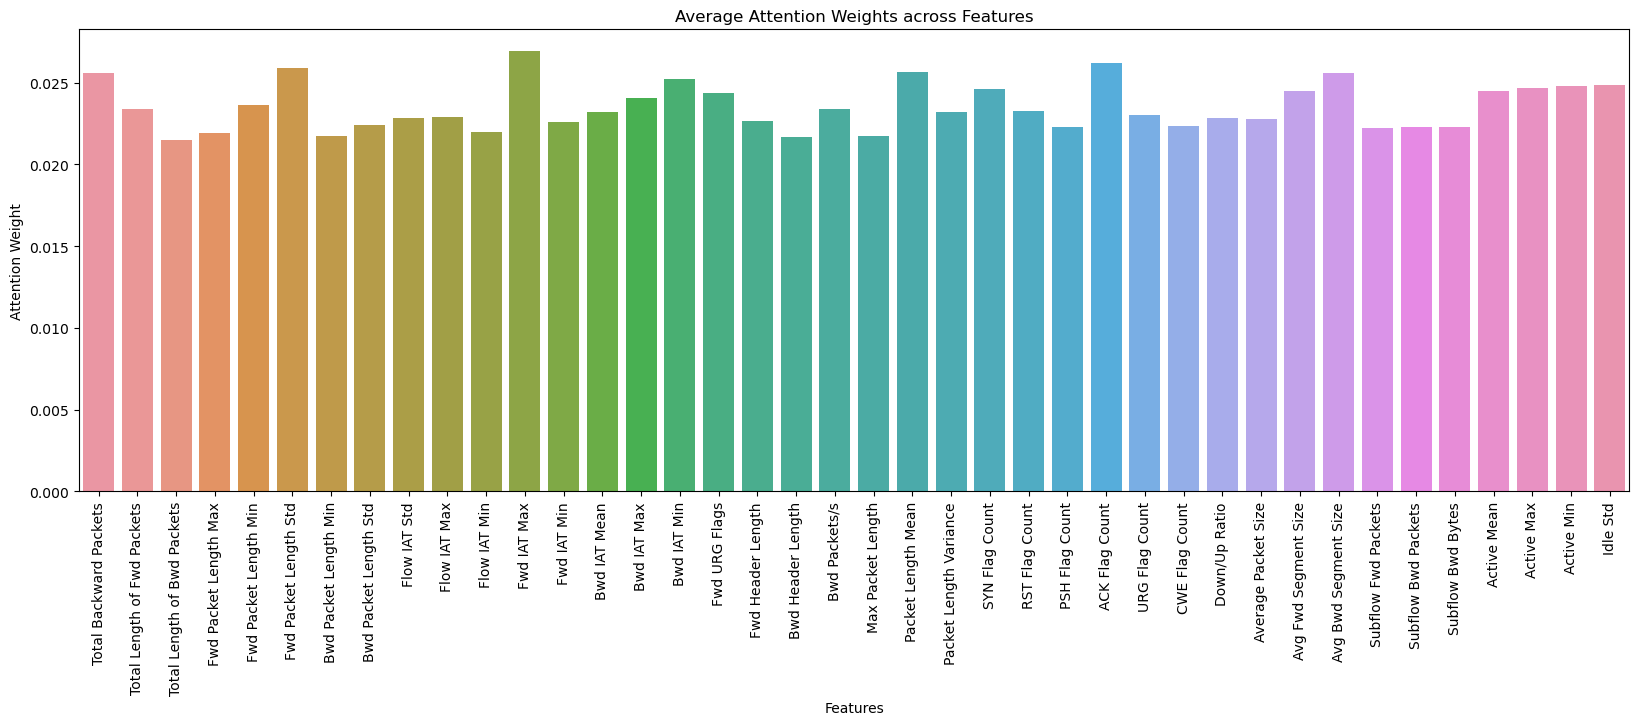

In [39]:
plt.figure(figsize=(20, 6))
sns.barplot(x='Feature', y='Attention Weight', data=attention_df)
plt.title('Average Attention Weights across Features')
plt.xlabel('Features')
plt.ylabel('Attention Weight')
plt.xticks(rotation=90)
plt.savefig('CIC-IDS_2017_attention_weight_binary.png')
plt.show()

17729/17729 ━━━━━━━━━━━━━━━━━━━━ 341s 19ms/step


C:\Users\ramya\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


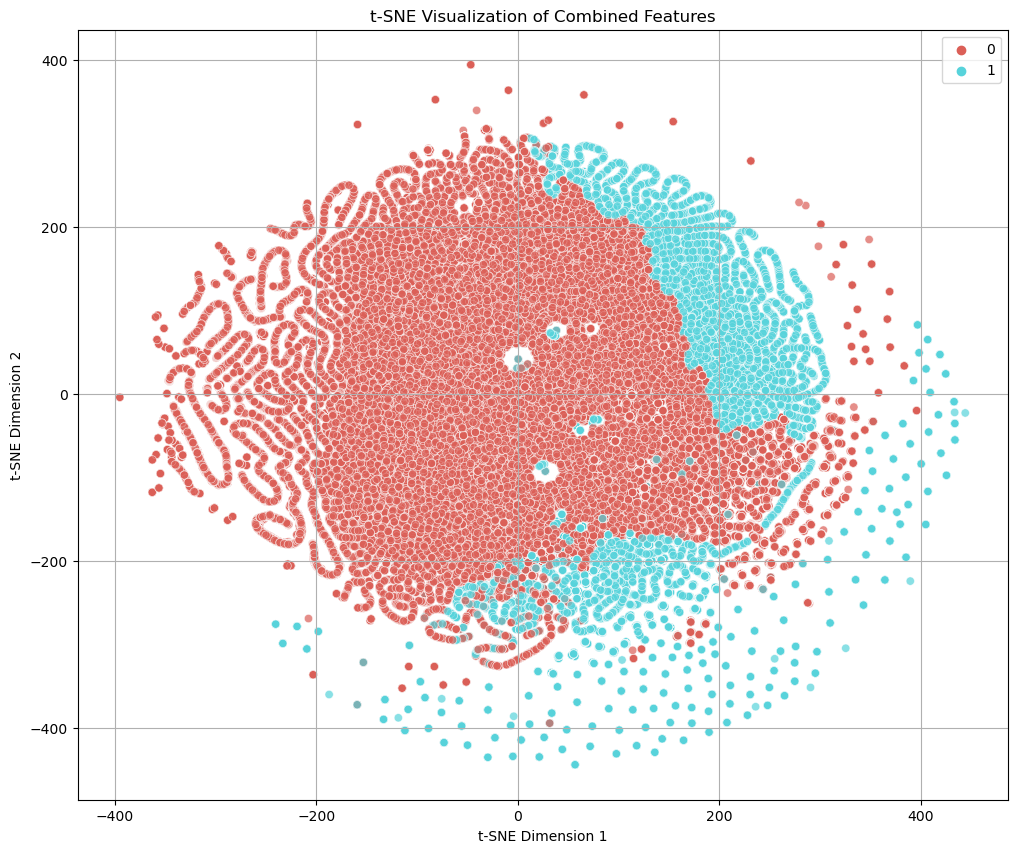

In [40]:
# t-SNE visualization (for binary classification)
from sklearn.manifold import TSNE

# Extract combined features from the ensemble model before the attention mechanism
feature_extractor = Model(inputs=ensemble_model.inputs, outputs=ensemble_model.get_layer('combined_features').output)
combined_features_test = feature_extractor.predict([X_test_cnn, X_test_cnn, X_test])

# Perform t-SNE to reduce the combined features to 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42)
tsne_results = tsne.fit_transform(combined_features_test)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame({
    't-SNE1': tsne_results[:, 0],
    't-SNE2': tsne_results[:, 1],
    'Label': y_test_binary
})

# Plot t-SNE results
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='t-SNE1', y='t-SNE2',
    hue='Label',
    palette=sns.color_palette('hls', 2),
    data=tsne_df,
    legend='full',
    alpha=0.7
)
plt.title('t-SNE Visualization of Combined Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('CIC_IDS2017_binary_t-SNE_Dec2024.png')
plt.show()


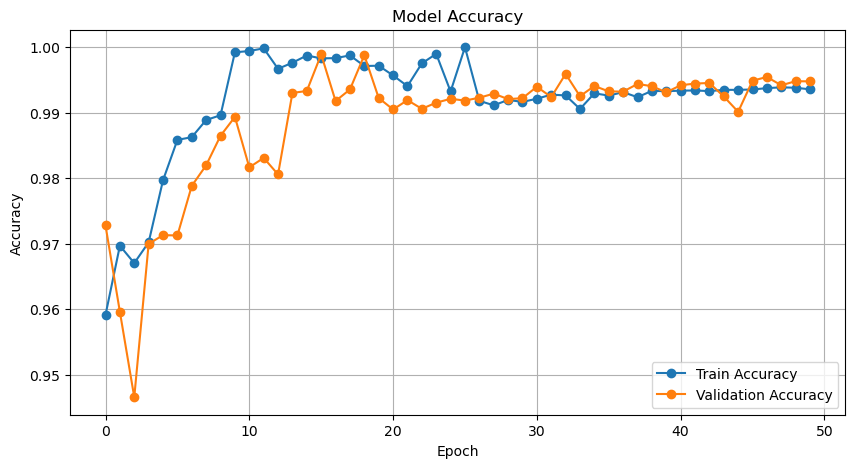

In [49]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("CIC-IDS_2017_Accuracy_binary_Dec2014.png")
plt.show()

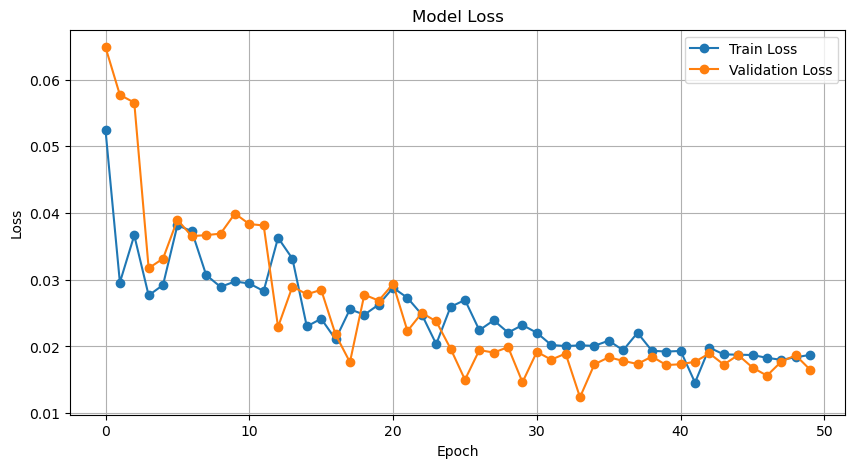

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("CIC-IDS_2017_loss_binary_Dec2024.png")
plt.show()

In [59]:
# Confusion matrix
y_pred = (ensemble_model.predict([X_test_cnn, X_test_cnn, X_test]) > 0.5).astype("int32")


17729/17729 ━━━━━━━━━━━━━━━━━━━━ 319s 18ms/step


In [79]:
import pickle

# Save arrays for future reproduction of results
with open('y_test_binary_CICIDS2017_Dec2024.pkl', 'wb') as file:
    pickle.dump(y_test_binary, file)
with open('y_pred_CICIDS2017_Dec2024.pkl', 'wb') as file:
    pickle.dump(y_pred, file)

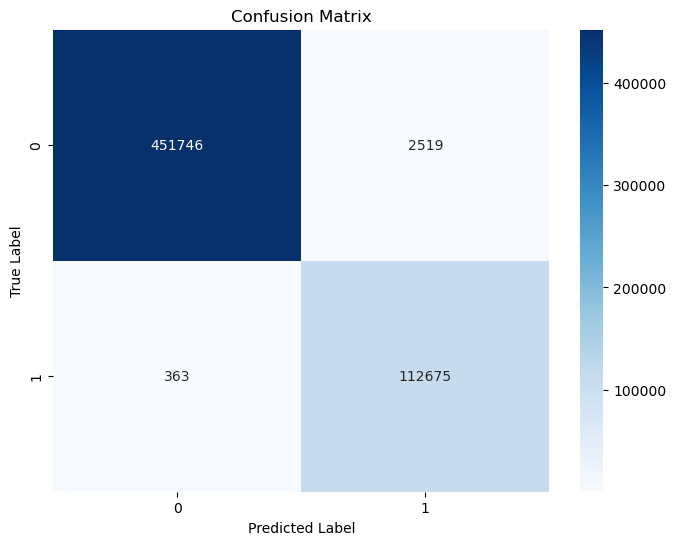

In [80]:
cm = confusion_matrix(y_test_binary, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('CIC-IDS_2017_confusion_matrix_binary_Dec2024.png')
plt.show()

In [81]:
# Classification report
report = classification_report(y_test_binary,  y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    454265
           1       0.98      1.00      0.99    113038

    accuracy                           0.99    567303
   macro avg       0.99      1.00      0.99    567303
weighted avg       0.99      0.99      0.99    567303



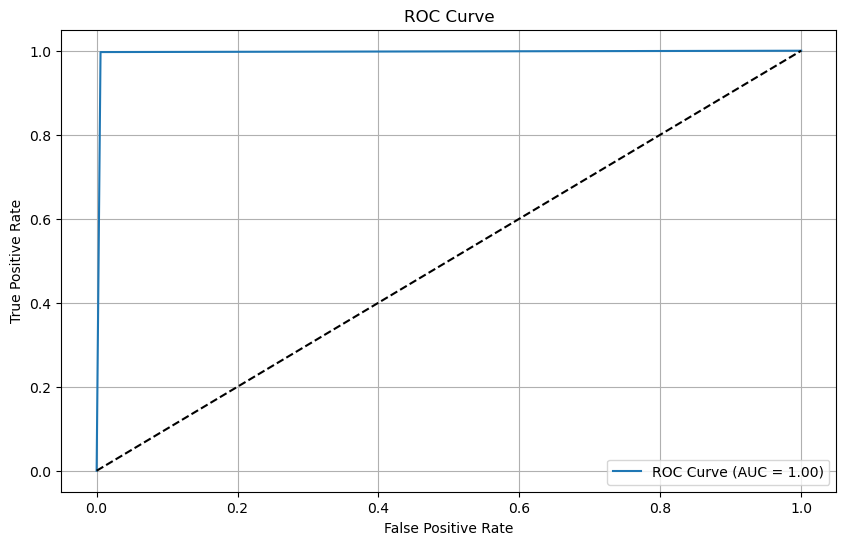

In [82]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test_binary,  y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("CIC-IDS_2017__binary_Dec2024.png")
plt.show()


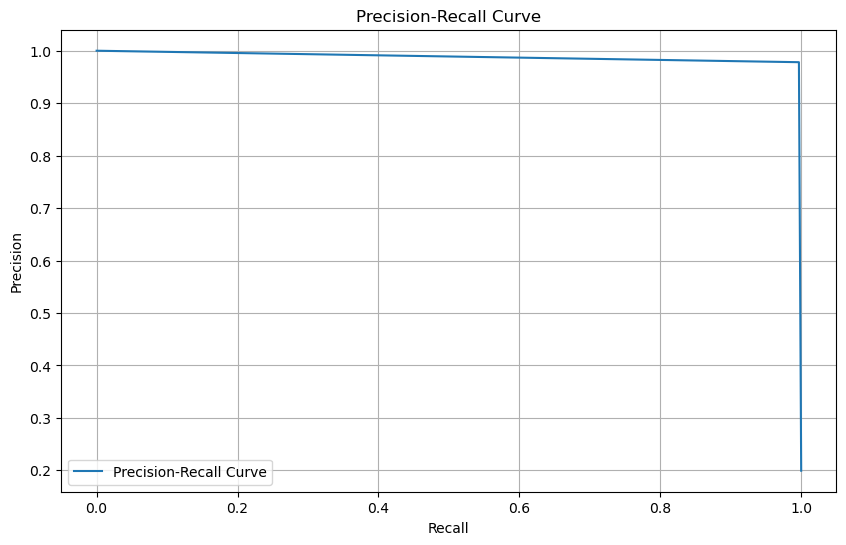

In [83]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_binary,  y_pred_modified)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.savefig("CIC-IDS_2017_recall_binary_Dec2024.png")
plt.show()